# Dropout
Sung-ju Kim
https://goddoe.github.io

- - -


## Content
1. Prepare pseudo data
2. Make model & Design cost function & optimizer
3. Train & Draw graph

- - -


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def pseudo_function(x, x_i, n_data):
    n_wave = 5
    exp_max = 1
    exp_min = -1
    bias = 0.5
    a = 1.5
    
    radian_unit = (np.pi * n_wave) / n_data
    exp_unit = (exp_max - exp_min) / n_data 
    
    y = np.sin(x_i*radian_unit)* np.exp(exp_max-(exp_unit*x_i)) + bias + a*x
    
    return y

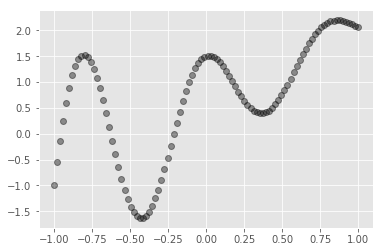

In [3]:
n_data = 100
x_range = (-1, 1)

X_train = np.linspace(-1, 1, n_data,dtype=np.float32)
Y_train = np.array([pseudo_function(x,x_i,n_data) for x_i, x in enumerate(list(X_train))], dtype=np.float32)
plt.cla()
plt.plot(X_train, Y_train, 'ro', alpha=0.4, color='black')

In [4]:
# reshape for model
X_train = np.reshape(X_train, newshape=[-1,1])
Y_train = np.reshape(Y_train, newshape=[-1,1])
print("X_train shape : {}\nY_train shape : {}".format(np.shape(X_train), np.shape(X_train)))

X_train shape : (100, 1)
Y_train shape : (100, 1)


## 2. Make model & Design cost function & optimizer

$${ u }_{ j }={ \phi  }_{ relu }(\sum _{ i=0 }^{ n }{ { w }_{ ij }{ x }_{ i } } )\quad { y }_{ l }={ \phi  }_{ relu }(\sum _{ j=0 }^{ m }{ { w }_{ jl }{ u }_{ j } } ) $$

$$ { x }_{ i }\quad :\quad i-th\quad value\quad of\quad input\quad x\\ { w }_{ ij }\quad :\quad weight\quad between\quad { x }_{ i }\quad and\quad { u }_{ j }\\ { u }_{ j }\quad :\quad activation\quad of\quad first\quad layer\\ { w }_{ jl }\quad :\quad weight\quad between\quad { u }_{ i }\quad and\quad { y }_{ l }\\ { \phi  }_{ relu }\quad :\quad relu\quad activation\quad function\quad$$

In [5]:
with tf.variable_scope('variable'):
    X = tf.placeholder(dtype=tf.float32, 
                       shape=[None,1],
                       name="X")
    Y = tf.placeholder(dtype=tf.float32,
                       shape=[None,1],
                       name="Y")
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    dropout_rate = tf.placeholder(dtype=tf.float32, name='dropout_rate')
    dropout_recovery = tf.placeholder(dtype=tf.float32, name='dropout_recovery')

In [6]:
"""
Signature: tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)
Docstring:
Computes dropout.

With probability `keep_prob`, outputs the input element scaled up by
`1 / keep_prob`, otherwise outputs `0`.  The scaling is so that the expected
sum is unchanged.
...

So you don't have to re-scale up layers' activation
"""


with tf.variable_scope('mlp_model'):
    # declaration of model
    
    h = tf.layers.dense(X, 16, name="layer_1", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    h = tf.nn.dropout(h, keep_prob=dropout_rate)
    h = tf.layers.dense(h, 16, name="layer_2", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    h = tf.nn.dropout(h, keep_prob=dropout_rate)
    Y_pred = tf.layers.dense(h, 1, name="layer_3")
    
    # optimization
    cost = tf.reduce_mean(tf.squared_difference(Y_pred, Y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

## 3. Train & Draw graph

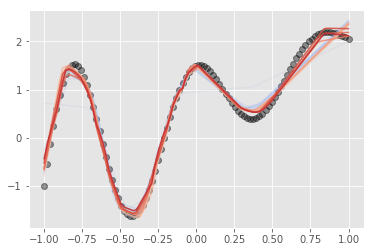

In [7]:
lr = 0.005
n_epoch = 6000

draw_interval = 300
plt.cla()
plt.plot(X_train, Y_train, 'ro', alpha=0.4, label="origin", color="black")

cmap = plt.get_cmap('coolwarm')
c_norm = colors.Normalize(vmin=0, vmax=n_epoch)
scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cmap)

sess = tf.Session() 
sess.run(init)
for epoch_i in range(n_epoch):
    _ = sess.run(optimizer, feed_dict={X:X_train, 
                                   Y:Y_train, 
                                   learning_rate:lr,
                                   dropout_rate:0.95,})
    if epoch_i % draw_interval == 0 :
        X_show = X_train.copy()
        Y_show = sess.run(Y_pred, 
                          feed_dict={X:X_show, dropout_rate:1.0})
        
        plt.plot(X_show, Y_show, alpha=epoch_i/n_epoch, color=scalar_map.to_rgba(epoch_i))